# CCE2502 Assignment II - Logistic Regression
### Year 2023-2024- Semester II
#### Adrian Muscat, 2024
### Assignment Completed by Jacob Ellul

In [15]:
# import useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Do not carry out any changes to the code in this cell

def lr_loss_function(y_target,y_predicted):
    """
    y_target: actual gold labels (vector of size(m,))
    y_predicted : predicted probabilities for positive class (vector of size (m,))
    returns categorical cross entropy loss
    """
    m=y_target.shape[0]
    L = -(y_target*np.log(y_predicted) + (1-y_target)*np.log(1-y_predicted)).sum()/m
    return L


def predict_y_prob(W,D):
    """
    W is the weight vector [[w_0],[w_1],[w_2],...] of size [N+1,1]
    where N is number of features, excluding bias
    D is the feature matrix [m,N] where m is the number of examples
    return a vector of size (m,1)
    """
    m = D.shape[0]
    bias = np.ones([m,1], dtype=float)
    X = np.concatenate((bias,D),axis=1)
    z = np.matmul(W.T,X.T)
    y = 1/(1+np.exp(-z))
    #
    return y.T

def get_accuracy(W,X,y):
    """
    W is the weight vector [[w_0],[w_1],[w_2],...] of size [N+1,1]
    where N is number of features, excluding bias
    X is the feature matrix [m,N] where m is the number of examples
    y is the gold label vector of size (m,)
    Computes and returns the accuracy in predicting the positive class and returns a scalar
    """
    Y_pred = (predict_y_prob(W,X)>=0.5).astype(int)
    #
    return (Y_pred.ravel()==y).astype(int).sum()/y.shape[0]

def display_results(model):
    #
    history_train_loss = model['history']['train_loss']
    history_val_loss = model['history']['val_loss']
    t=range(len(history_train_loss))
    p1, p2 = plt.plot(t,history_train_loss,'b',t,history_val_loss,'r')
    plt.legend([p1,p2], ['Train loss','Val loss'])
    #
    print('train acc : ', model['train_acc'])
    print('val acc   : ', model['val_acc'])
    #
    print('Weights : ', model['weights'].ravel())
    return 0

# Use this function for plotting datasets as scatter graphs
def data_scatter_plot(X,y):
    """
    Plots a scatter graph for a 2-D dataset
    X : Feature numpy array of size (m,N), 
            m=number of examples (rows)
            N = number of features (columns)
            If N>2, first two features taken in consideration
    y : Output label numpy array of size (m,1) or (m,)
    """
    mk ={0:'or', 1:'ob'}
    plt.plot(X[:,0][y[:]==0] , X[:,1][y[:]==0], mk[0])
    plt.plot(X[:,0][y[:]==1] , X[:,1][y[:]==1], mk[1])

In [17]:
# Gradient Descent algorithm that learns the model parameters
# The update equations require the partial derivatives of the loss function
# with respect to the weights or parameter of the model
#
def lr_train_model(X_data, 
                   y_data, 
                   reshuffle = 'yes',
                   split_frac=0.8, 
                   init_weights=0.00001, 
                   no_iterations=2000,
                   alpha = 0.001,
                   phi = 0.001):
    """
    X_data : data feature matrix (including bias x_0 = 1.0)
    y_data : data output values
    split_frac : data split fraction, we require the split to compute validation mse
        if split_frac = -1 (or negative), then dataset is not split and train and val portions are the same
    init_weights : initial weights (all same value)
        if init_weights = -1 (or negative), then random weights are chosen
    alpha : learning rate
    phi : regularisation constant
    W : weights vector
    """
    #
    idx = np.arange(0, y_data.shape[0])
    if reshuffle == 'yes':
        np.random.shuffle(idx)
    X_data = np.copy(X_data[idx])
    y_data = np.copy(y_data[idx])
    #
    if split_frac < 0.0:
        y_train, y_val, X_train, X_val = y_data, y_data, X_data, X_data
    else:
        split = int(y_data.shape[0]*split_frac)
        y_train, y_val, X_train, X_val  = y_data[0:split], y_data[split:], X_data[0:split], X_data[split:]
    #
    N = X_data.shape[1] # number of features
    print("Number of input features :",N)
    if init_weights < 0.0:
        W = 0.5*(np.random.rand((N+1))-0.5).reshape(N+1,1)
    else:
        W = np.full((N+1,1), init_weights) # initialise weight vectors to the same value
    print("Initial Weights:",W)
    m=y_train.shape[0]
    history_loss=[]
    history_val_loss=[]
    #
    for itr in range(no_iterations):
        y_pred_pr = predict_y_prob(W,X_train).ravel()
        loss = lr_loss_function(y_train,y_pred_pr)
        history_loss.append(loss)
        history_val_loss.append(lr_loss_function(y_val,predict_y_prob(W,X_val).ravel()))
        # Task1D: 
        #######################################################################
        errors = np.zeros(N+1)  # Initialize gradient array
        errors[0] = np.sum(y_pred_pr - y_train)  # Bias term gradient, no regularization
        errors[1:] = X_train.T.dot(y_pred_pr - y_train) + phi * W[1:].ravel() # Gradient for weights with regularization
        W -= alpha * errors.reshape(-1, 1) # Update the weights
        #######################################################################
    #
    #
    return {'weights':W, 
            'history':{'train_loss':history_loss,
                                    'val_loss':history_val_loss},
            'train_acc':get_accuracy(W,X_train,y_train),
            'val_acc':get_accuracy(W,X_val,y_val)}

# TASK 1

## 1A
Use the csv python module to load the data in the binary_classification_basic.csv file. The first
two columns are the input features (X1, X2) and the third column is the output variable (y)

In [18]:
import csv

file_path = 'binary_classification_basic.csv'

# Initialize lists to hold the feature vectors and labels
features = []
labels = []

# Open the CSV file and read its contents
with open(file_path, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    
    # Read each row in the CSV file
    for row in csv_reader:
        # Convert the first two columns (X1, X2) to float and add to the features list
        features.append([float(row[0]), float(row[1])])
        # Convert the third column to float (label) and add to the labels list
        labels.append(float(row[2]))

X1_basic = np.array(features)
y1_basic = np.array(labels)

## 1B
Using the function provided, plot the scatter graph

Text(0.5, 1.0, 'Scatter Plot of Input Features')

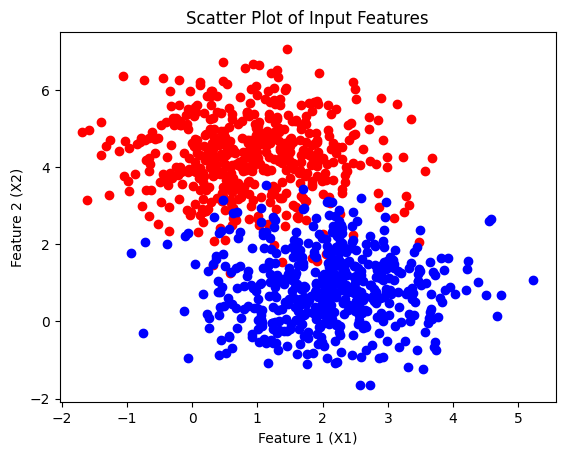

In [19]:
data_scatter_plot(X1_basic, y1_basic)
plt.xlabel('Feature 1 (X1)')
plt.ylabel('Feature 2 (X2)')
plt.title('Scatter Plot of Input Features')

## 1C
The regularized categorical cross entropy loss function is given below. Derive the partial
derivatives of the loss function with-respect-to the model parameters, w. (Note: include the
result in the juypter notebook using mathjax and scan and attach all workings in the zip file).

Where m is the number of examples in the dataset, i is an index to the ith example, t is the target
variable, x is the input vector and w is the weight vector. 

\begin{equation}
\frac{\partial L(w)}{\partial w} = -\frac{1}{2m}[\sum_{i=1}^{m} (t^{(i)} - \overline{y})(\sum_{j=1}^{N} x_j^{(i)})] + 2 \phi  \sum_{j=1}^{N} w_j
\end{equation}



## 1E:
Using the lr_train_model() function train a model on the binary_classification_basic dataset.
Remember to make use of the display_results() function to get insight and debug the model.

Number of input features : 2
Initial Weights: [[1.e-05]
 [1.e-05]
 [1.e-05]]
train acc :  0.95875
val acc   :  0.95
Weights :  [ 6.56964941  0.8311006  -3.03019373]


0

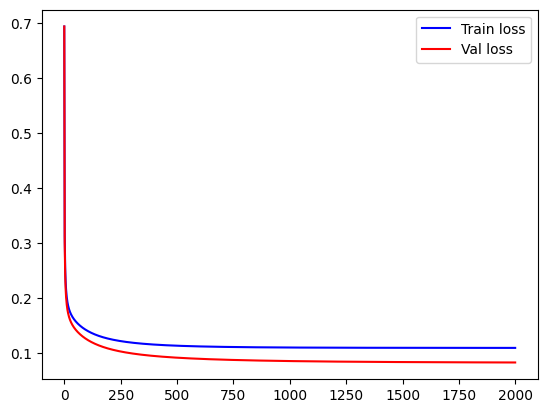

In [20]:
model = lr_train_model(X1_basic, y1_basic)
display_results(model)


The graph shows the training and validation loss over the training iterations. As can be seen, both losses decrease sharply and then level off, indicating that the model quickly learns to minimize errors and stabilizes with further training. The losses are very close throughout, which indicates to us that the model is neither overfitting nor underfitting significantly.

## 1F: 

Superimpose the decision boundary learnt by the model onto the dataset scatter plot.

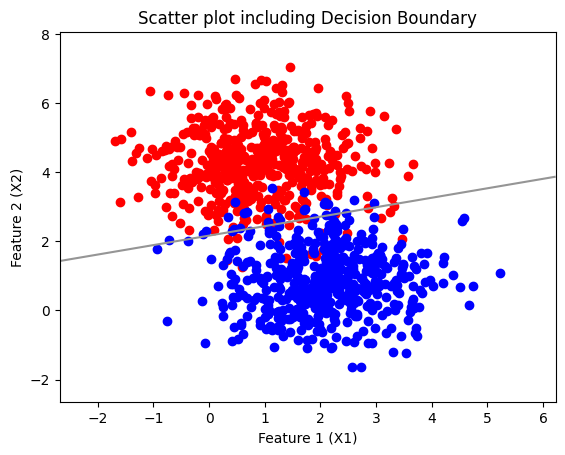

In [21]:
def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary for the logistic regression model.
    
    Paraneters:
        model (dict): A dictionary containing the model's parameters, including weights.
        X (numpy array): Feature matrix of size (m, n), where m is the number of examples and n is the number of features.
        y (numpy array): Target labels of size (m,).
    """
    W = model['weights']
    data_scatter_plot(X, y)
    
    # Create a grid of points to plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    # Flatten the grid to pass into model
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = predict_y_prob(W, grid).reshape(xx.shape)
    
    # Plot decision boundary where probability is 0.5
    plt.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=1)
    plt.xlabel('Feature 1 (X1)')
    plt.ylabel('Feature 2 (X2)')
    plt.title('Scatter plot including Decision Boundary')
    plt.show()

# Plotting the decision boundary
plot_decision_boundary(model, X1_basic, y1_basic)


The above figure is the decision boundary plotted using the weights learned by the trained model. The boundary line is a point where the model gives a 50% probability to either class (equal probability). As can be observed the decision boundary correctly splits the two classes based on the input features given to it in training.

# TASK 2


## 2A:
Use the csv python module to load the data in the binary_classification_advanced.csv file. The
first two columns are the input features (X1, X2) and the third column is the output variable (y).

In [22]:
file_path = 'binary_classification_advanced.csv'

# Initialize lists to hold the feature vectors and labels
features_X1 = []
features_X2 = []
labels = []

# Open the CSV file and read its contents
with open(file_path, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    
    # Read each row in the CSV file
    for row in csv_reader:
        # Convert the first two columns to float and add to respective features list
        # Changed from the first method due to Task 2D, having two easily accessible features simplfies the process
        features_X1.append(float(row[0]))
        features_X2.append(float(row[1]))
        # Convert the third column to float and add to the labels list
        labels.append(float(row[2]))

X_advanced = np.array([features_X1, features_X2]).T
y_advanced = np.array(labels)

## 2B:
Using the function provided plot the scatter graph.

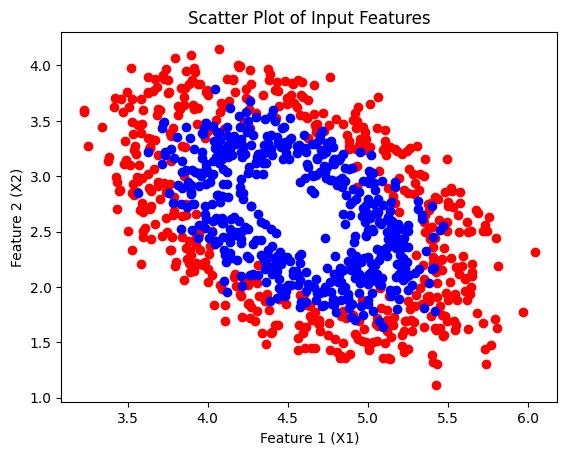

In [23]:
data_scatter_plot(X_advanced,y_advanced)
plt.xlabel('Feature 1 (X1)')
plt.ylabel('Feature 2 (X2)')
plt.title('Scatter Plot of Input Features')
plt.show()

## 2C:

Using the lr_train_model() function, train a model on the binary_classification_advanced
dataset and explain any poor result.

Number of input features : 2
Initial Weights: [[1.e-05]
 [1.e-05]
 [1.e-05]]
train acc :  0.48625
val acc   :  0.555
Weights :  [ 0.80954868 -0.29325259 -1.24526043]


0

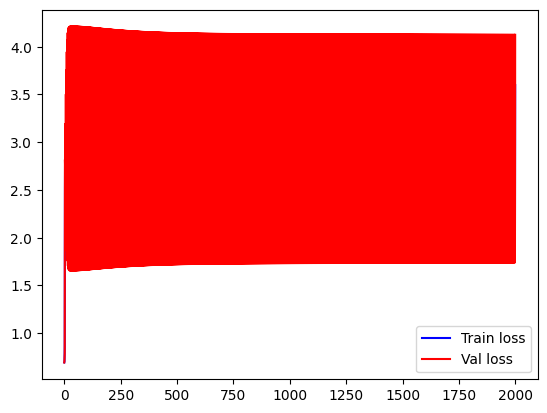

In [24]:
result_advanced = lr_train_model(X_advanced, y_advanced) 
display_results(result_advanced)

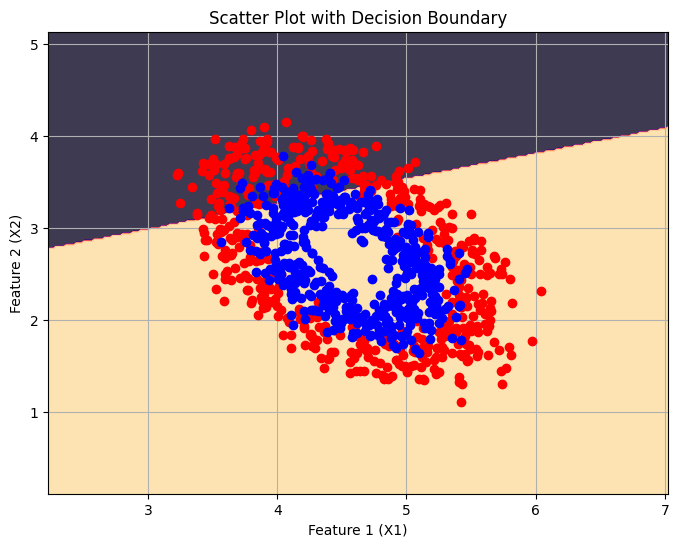

In [25]:

def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary for a logistic regression model and overlays the data points.
    
    Parameters:
        model (dict): A dictionary containing the model's parameters, including weights.
        X (numpy array): Feature matrix of size (m, n), where m is the number of examples and n is the number of features.
        y (numpy array): Target labels of size (m,).
    """
    # Extract weights from the model
    W = model['weights']

    # Create a grid of points to plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Compute the model's predictions
    Z = predict_y_prob(W, np.c_[xx.ravel(), yy.ravel()])
    Z = (Z >= 0.5).astype(int)  # Convert probabilities to class labels
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='magma')

    # Plot the scatter plot of the data
    data_scatter_plot(X, y)
    plt.xlabel('Feature 1 (X1)')
    plt.ylabel('Feature 2 (X2)')
    plt.title('Scatter Plot with Decision Boundary')
    plt.grid(True)
    plt.show()

plot_decision_boundary(model, X_advanced, y_advanced)

### Discussing Poor Results:

The issue seen with the accuracy of the model being much lower than the previous datataset is entirely due to the shape of the dataset (non-linearly seperable). A linear boundry is not able to split a 2d torus encapsulated by another 2d torus. 

The way to improve this would be to use a curved boundry instead of a linear one as this  would model the data we have much better. We can implement a curved boundry by adding Polynomial features, or using a neural network. Both of these are shown later on.


## 2D:

Manually, find higher order terms of the input features (X1, X2) that improve the classification
accuracy. Explain your answer and your reasoning. 

Number of input features : 14
Initial Weights: [[1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]]


/tmp/ipykernel_343403/2786367909.py:25: RuntimeWarning: overflow encountered in exp
  y = 1/(1+np.exp(-z))
/tmp/ipykernel_343403/2786367909.py:10: RuntimeWarning: divide by zero encountered in log
  L = -(y_target*np.log(y_predicted) + (1-y_target)*np.log(1-y_predicted)).sum()/m
/tmp/ipykernel_343403/2786367909.py:10: RuntimeWarning: invalid value encountered in multiply
  L = -(y_target*np.log(y_predicted) + (1-y_target)*np.log(1-y_predicted)).sum()/m


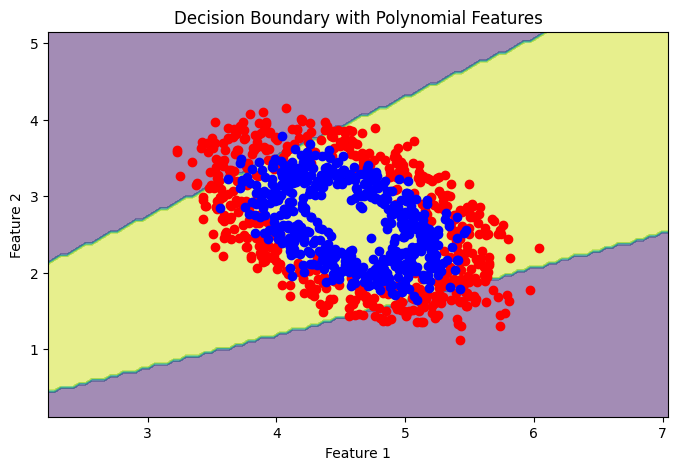

train acc :  0.64625
val acc   :  0.675
Weights :  [   -3.23685286    18.42127324     5.7649627    141.69558075
    88.30999857     6.42130805   485.36132938   452.40142052
   116.76226945  -126.4272606   -542.5865186   1246.0708036
   330.69496056  -569.97233011 -1094.0309924 ]


0

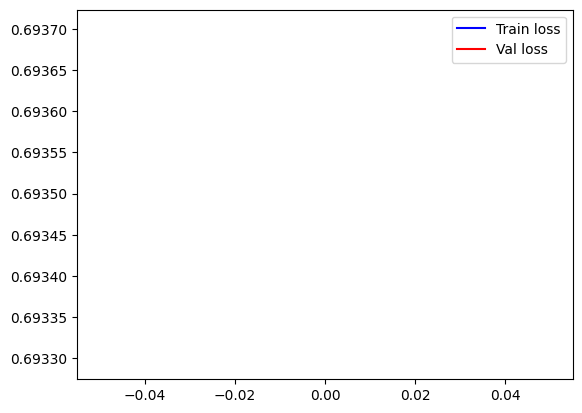

In [26]:
def plot_decision_boundary(X, y, weights, degree):
    """
    Plots the decision boundary based on the degree of polynomial features used.
    
    Parameters:
        X (numpy array): Feature matrix of size (m, 2), where m is the number of examples and 2 is the number of features.
        y (numpy array): Target labels of size (m,).
        weights (numpy array): Model weights of size (n+1,), where n is the number of features including polynomial features.
        degree (int): Degree of polynomial features used.
    """
    # Define the range for the features
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a mesh grid for the feature space
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    grid = np.column_stack((xx1.ravel(), xx2.ravel()))

    # Generate polynomial features for the grid
    grid_poly = generate_polynomial_features(grid, degree)

    # Compute the model's predictions
    probs = predict_y_prob(weights, grid_poly).reshape(xx1.shape)
    
    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(8, 5))
    plt.contourf(xx1, xx2, probs, alpha=0.5, cmap=plt.cm.viridis)
    
    # Plot the scatter plot of the data
    data_scatter_plot(X, y)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary with Polynomial Features')
    plt.show()
    

def generate_polynomial_features(X, degree):
    """
    Generates polynomial features for given input matrix X up to the specified degree.

    Parameters:
        X (numpy array): Feature matrix of size (m, 2), where m is the number of examples and 2 is the number of features.
        degree (int): Degree of polynomial features to generate.
    """
    if X.shape[1] != 2:
        raise ValueError(f"function needs a 2D feature matrice. Receieved {X.shape[1]} features instead")
    
    # Initialize with original features
    X_poly = X.copy()

    # Generate higher degree terms
    for i in range(2, degree+1):
        for j in range(i+1):
            X_poly = np.column_stack((X_poly, (X[:, 0]**(i-j)) * (X[:, 1]**j)))
    return X_poly

degree = 4

X_poly = generate_polynomial_features(np.column_stack((features_X1, features_X2)), degree) # Generate polynomial features for the input data
result_poly = lr_train_model(X_poly, y_advanced) # Train the model using the polynomial features
plot_decision_boundary(X_poly[:, :2], y_advanced, result_poly['weights'] , degree) 
display_results(result_poly) 

## Explaining Results

I chose 4 as the best degress for the decision boundary as it resulted with the most accurate plot. Choosing smaller or larger degrees resulted in less accurate plots and more errors. Altough this degree contains errors as can be observed above when generating the plot it still performs better than the other degrees (with the same or less errors) for my code at least. It is noted though that adding higher order terms does result in a slightly more accurate model. However still a decision boundary is not the way to model this kind of data. The next task shows a far superior approach.

## TASK 3

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

## 3A: 

Neural networks are used to model complex, non-linear relationships through their architecture, which comprises layers of interconnected nodes or "neurons." Each neuron processes its input with a non-linear activation function. By changing weights with error-based learning, the network can understand complex patterns. Hidden layers allow the network to generate different combinations of characteristics at different levels of abstraction, enabling the classification of non-linearly separable data and improving prediction accuracy.

## 3B: 
Use the sklearn.neural_network.MLPClassifier() module to learn a non-linear model for the binary_classification_advanced dataset.

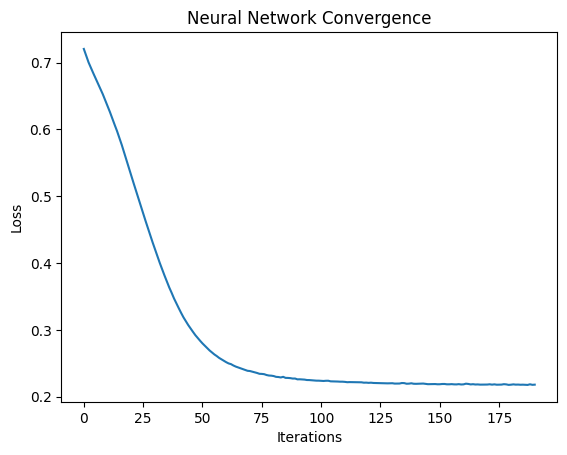

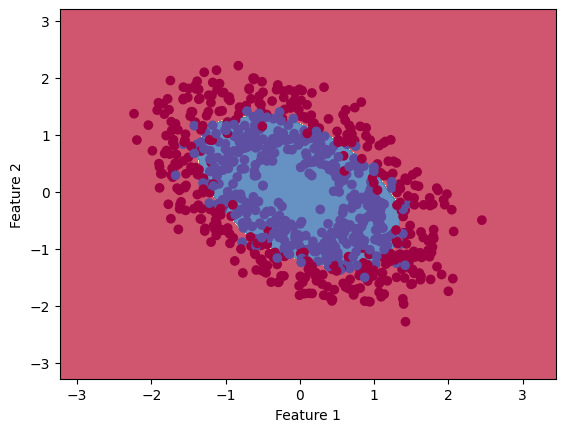

Accuracy on test set: 0.91


In [28]:
from sklearn.discriminant_analysis import StandardScaler

# Load the dataset again (needs to be fresh otherwise this causes errors)
X_advanced = np.array([features_X1, features_X2]).T
y_advanced = np.array(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_advanced)

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_advanced, test_size=0.2, random_state=42)

# Create MLPClassifier instance with a potential structure
mlp = MLPClassifier(hidden_layer_sizes=(50, 30), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Plot the convergence of the neural network
plt.plot(mlp.loss_curve_)
plt.title('Neural Network Convergence')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

def plot_decision_boundary(mlp, X, y):
    """
    Plots the decision boundary for a neural network model.

    Parameters:
        mlp (MLPClassifier): A trained MLPClassifier model.
        X (numpy array): Feature matrix of size (m, 2), where m is the number of examples and 2 is the number of features.
        y (numpy array): Target labels of size (m,).
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) # Looks better over given scatter_plot function
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot results and show accuracy
plot_decision_boundary(mlp, X_train, y_train)
accuracy = mlp.score(X_train, y_train)
print(f"Accuracy on test set: {accuracy:.2f}")

## 3C:
Explain how you would check whether the neural network is performing as it should, without computing the accuracy or any other quantitative evaluation metric. 


### Without computing accuracy or other metrics, one can qualitatively evaluate the neural network's performance by:

1. Visual Inspection: Plot the decision boundaries learned by the network and compare them with the data distribution. We can visually assess if it's correctly splitting the different classes according to the data distribution.

2. Learning Curves: Observe the training process over epochs; the loss should decrease steadily. Abrupt changes or plateaus likely indicate issues.

3. Compare with Baseline Models: We can check if the neural network is performing better qualitatively compared to simpler models or random guessing. Providing us with a baseline on how the neural network should at least perform.

4. Multiple Runs: If running the neural network multiple times yields consistent results, then we can verify that it is performing as expected. Also if there are consistent outliers or inconsistencies then we can deduce that it isn't performing as it should.